In [38]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [39]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure 2 is based on several important BED-files ...

In [41]:
feat_names = OrderedDict()
feat_names["tss"] = "allTSS-NO-G4"
feat_names["g4"] = "G4-NO-TSS"


## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [42]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end"],
        usecols=(0,1,2),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)
# merge_radius = 500
# df_merged = bf.merge(df, min_dist=merge_radius)
# print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


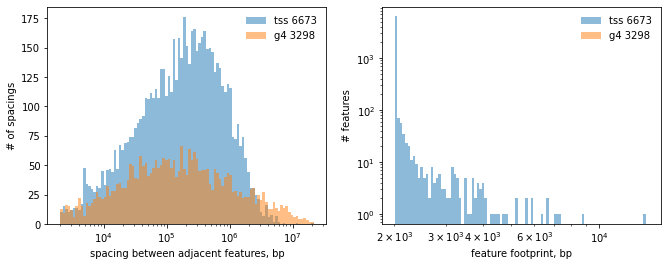

In [43]:
# just an overview of all of them together ...
plot_spacing_footprint_distros(dfs)
# plot_spacing_footprint_distros({k:dfs[k] for k in ['ctcf']})
# plot_spacing_footprint_distros({k:dfs[k] for k in ['ctcf_g4']})
# plot_spacing_footprint_distros({k:dfs[k] for k in ['g4']})
# plot_spacing_footprint_distros({k:dfs[k] for k in ['allg4']})

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

### Not sure if we'd need to do it here, given the lare footprint of the G4 related peaks !!!...

### let's have the original CTCF and RAD21 peak calls here to do count them along our stackups as well...

In [44]:
# G4-seq : G4 stalled at polymerase, more comprehensive list (hg19):
# G4-seq data https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63874
# ls ../GSE*bed.gz
# require tr -s '\t' - to remove duplicated tabs
# we've got + and - strand G4s separately ...
G4_minus_polstall = bioframe.read_table(
    "../GSE63874_Na_K_PDS_minus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = bioframe.read_table(
    "../GSE63874_Na_K_PDS_plus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = G4_plus_polstall.sort_values(["chrom","start"])
G4_plus_polstall = G4_plus_polstall[ G4_plus_polstall["chrom"].isin(autosomal_chroms) ]
G4_plus_polstall = G4_plus_polstall.reset_index(drop=True)
print(f"G4+ alone {len(G4_plus_polstall)} ...")

G4_minus_polstall = G4_minus_polstall.sort_values(["chrom","start"])
G4_minus_polstall = G4_minus_polstall[ G4_minus_polstall["chrom"].isin(autosomal_chroms) ]
G4_minus_polstall = G4_minus_polstall.reset_index(drop=True)
print(f"G4- alone {len(G4_minus_polstall)} ...")

G4_polstall = bf.merge(
    pd.concat([G4_plus_polstall,G4_minus_polstall]).reset_index(drop=True), # !!! Achtung !!! resetting_index is Yber important here!
#     min_dist=merge_radius
)
G4_polstall = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
print(f"G4-+ together {len(G4_polstall)}, would have been {len(G4_plus_polstall)+len(G4_minus_polstall)} ...")

G4+ alone 198824 ...
G4- alone 195394 ...
G4-+ together 378344, would have been 394218 ...


### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [45]:
#let's describe our samples that we want to have in Figure 1 ...
fig2_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","polII","mrna_ctcf","mrna_noctcf", "h3k4_r1", "h3k4_r2", "h3k4_input"] #,"ddx_CTCF","ddx_noCTCF"]
# plot_samples = ['ddx_CTCF','ddx_noCTCF','taf5l_CTCF','taf5l_noCTCF','input_CTCF','input_noCTCF',"ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","polII","mrna_ctcf","mrna_noctcf"]

titles = fig2_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in fig2_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = None

### next is computation heavy step - stackups using bbi ...

In [46]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks( bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features tss:(6673) ...


stacking up ctcf ...
CPU times: user 1.14 s, sys: 104 ms, total: 1.24 s
Wall time: 1.25 s
stacking up noctcf ...
CPU times: user 1.1 s, sys: 76 ms, total: 1.17 s
Wall time: 1.17 s
stacking up rad21_CTCF ...
CPU times: user 1.3 s, sys: 89.8 ms, total: 1.39 s
Wall time: 1.39 s
stacking up rad21_noCTCF ...
CPU times: user 1.04 s, sys: 63.8 ms, total: 1.1 s
Wall time: 1.11 s
stacking up ins_CTCF ...
CPU times: user 942 ms, sys: 108 ms, total: 1.05 s
Wall time: 1.05 s
stacking up ins_noCTCF ...
CPU times: user 927 ms, sys: 52.2 ms, total: 979 ms
Wall time: 976 ms
stacking up G4a_r2 ...
CPU times: user 1.62 s, sys: 87.9 ms, total: 1.71 s
Wall time: 1.7 s
stacking up polII ...
CPU times: user 942 ms, sys: 72.3 ms, total: 1.01 s
Wall time: 1.02 s
stacking up mrna_ctcf ...
CPU times: user 834 ms, sys: 48.1 ms, total: 882 ms
Wall time: 880 ms
stacking up mrna_noctcf ...
CPU times: user 827 ms, sys: 88.4 ms, total: 915 ms
Wall time: 909 ms
stacking up h3

### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [47]:
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

# subtract = "mean_top"
# subtract_size = 7
for feature_key in stackup_dict:
    normalize_insulation_stackups_INPLACE(
        stackups_set = stackup_dict[feature_key],
        ins_keys = insulation_keys
    )

In [48]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.452,-.153)
    cmps[s] = cmapYlGnBu_r

In [68]:
# turn RNA-seq into log-scale ... - probably should use "norm" instead !!!!
for s in  ["h3k4_r1", "h3k4_r2", "h3k4_input"]:
    limss[s] = (0.,10)

In [49]:
# turn RNA-seq into log-scale ... - probably should use "norm" instead !!!!
for s in ["mrna_ctcf", "mrna_noctcf"]:
    limss[s] = (0.,3)    
for s in ["mrna_ctcf", "mrna_noctcf"]:
    stackups[s] = np.log(stackups[s])

In [50]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in stackup_dict:
    the_stackups = stackup_dict[feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = the_stackups['ctcf'].shape
    center_bin = int(width/2)
    the_stackups['ctcf_mean'] = np.nanmean(the_stackups['ctcf'][:,center_bin-1:center_bin+1],axis=1)
    the_stackups['rna'] = np.nanmean(the_stackups['mrna_ctcf'][:,:],axis=1)
    # the_stackups['rad21_mean'] = np.nanmean(the_stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    _, _jjj = recursive_data_ordering(
        ks = [('rna', "sort", 1, False)],
        idxs = np.arange( len(the_stackups['ctcf_mean']) ),
        data_dict = the_stackups,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 6673 elements of rna into 1 groups ...
sorting 3298 elements of rna into 1 groups ...


### calculate running average (in chunks of 100) number of called peaks along the stackup

In [51]:
# #
# # skipping this for now ....
# #
CHUNK_SIZE = 100
# index_chunks = chunked(df_merged.loc[jjj].index, CHUNK_SIZE)
# ctcf_peaks_sorted = []
# for ii in index_chunks:
#     _df1 = df_merged.loc[ii][["chrom","start","end"]].reset_index(drop=True)
#     _df2 = ctcf_df
#     ctcf_peaks_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
    
# index_chunks = chunked(df_merged.loc[jjj].index, CHUNK_SIZE)
# rad21_peaks_sorted = []
# for ii in index_chunks:
#     _df1 = df_merged.loc[ii][["chrom","start","end"]].reset_index(drop=True)
#     _df2 = rad21_df
#     rad21_peaks_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
    
# index_chunks = chunked(df_merged.loc[jjj].index, CHUNK_SIZE)
# rad21IAA_peaks_sorted = []
# for ii in index_chunks:
#     _df1 = df_merged.loc[ii][["chrom","start","end"]].reset_index(drop=True)
#     _df2 = rad21_IAA_df
#     rad21IAA_peaks_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())

G4_polstall_sorted = {}
Number_of_chunks = {}
for feature_key in ['tss', 'g4']:
    jjj = reordered_jdxs[feature_key]
    features_df = dfs[feature_key]
    # G4_polstall
    index_chunks = chunked(features_df.loc[jjj].index, CHUNK_SIZE)
    G4_polstall_sorted[feature_key] = []
    Number_of_chunks[feature_key] = 0
    _df2 = G4_polstall # works as is !!!
    for ii in index_chunks:
        _df1 = features_df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
        G4_polstall_sorted[feature_key].append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
        Number_of_chunks[feature_key] += 1

#### plotting those running averages is integrated into `plot_stackups` function ...

In [52]:
##############################################
# now we'll be plotting stackups for different feature independently ...
#############################################
print('tss', 'g4')

tss g4


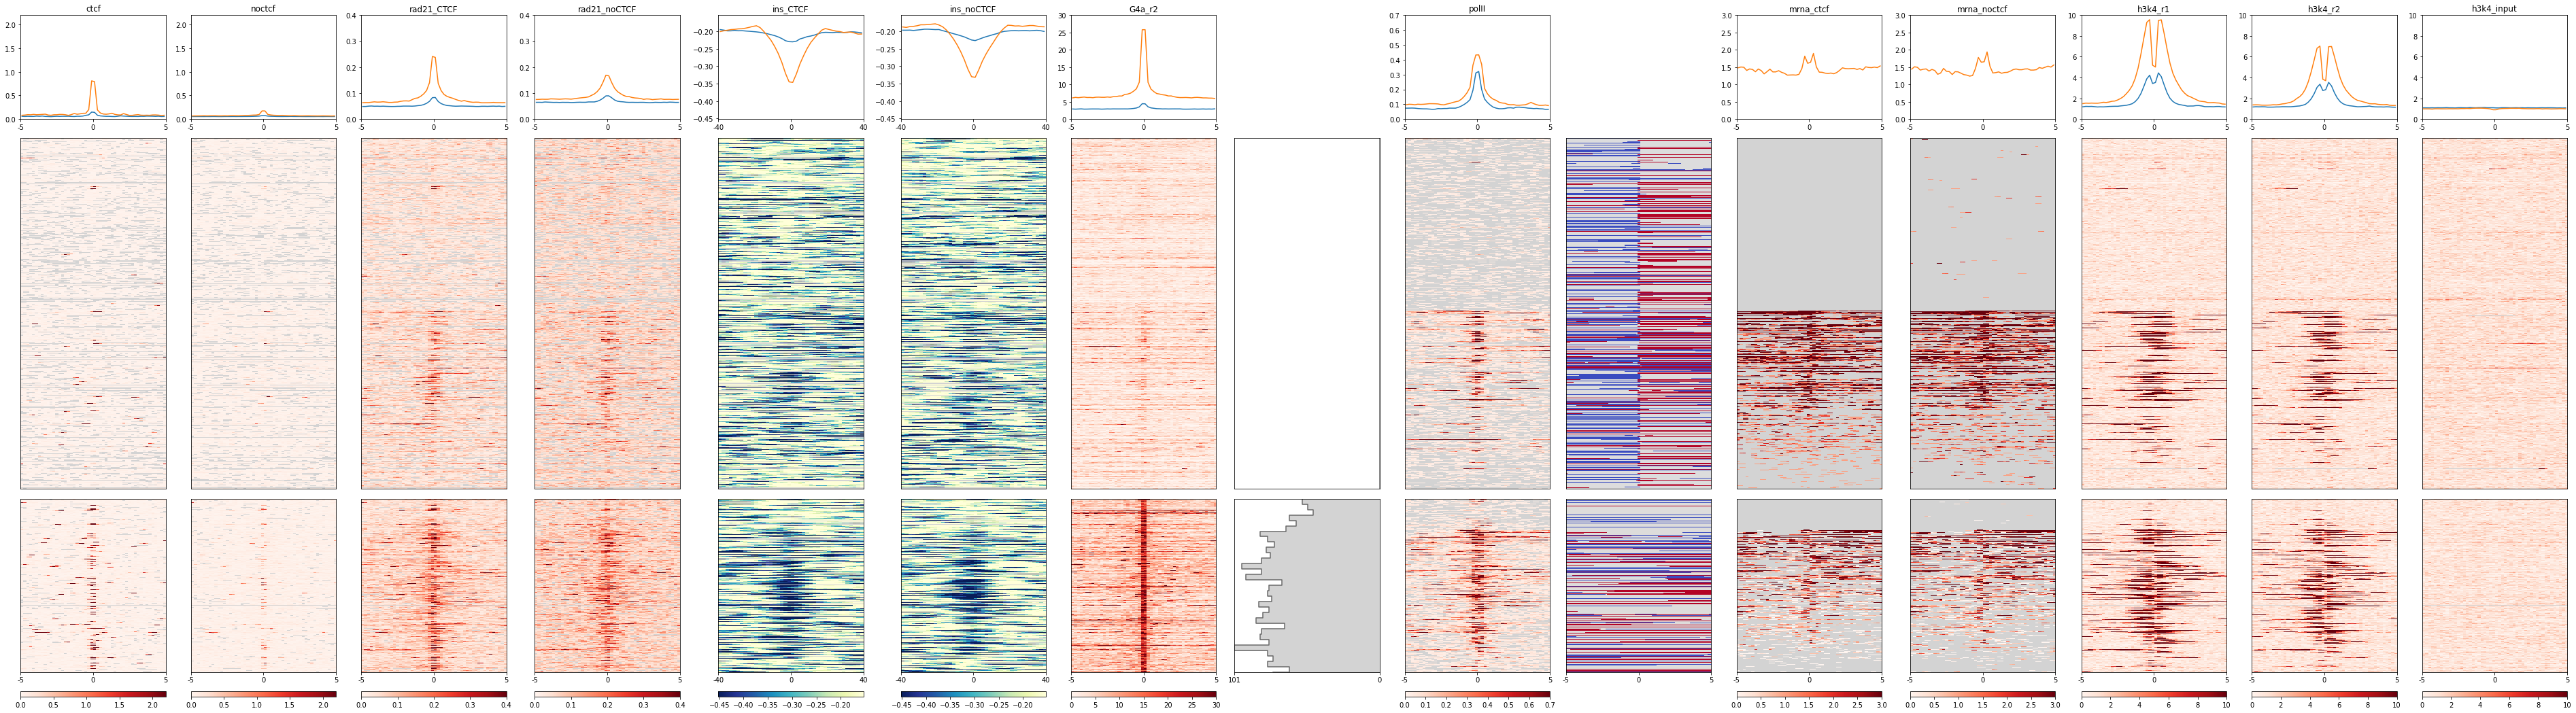

In [69]:
hmss = OrderedDict()

for feature_key in ['tss', 'g4']:
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in fig2_samples ]

_limss = [ limss[_k] for _k in fig2_samples ]
_cmps = [ cmps[_k] for _k in fig2_samples ]
_binsizes = [ binsizes[_k] for _k in fig2_samples ]
_norms = [ norms[_k] for _k in fig2_samples ]

# xtra_plots = [1,2]
extra_order = [7,9]
hmss_order = [0,1,2,3,4,5,6,8,10,11,12,13,14]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

# DEAL WITH XTRA PLOTS MANUALLY - AFTERWARDS ...
#     for idx in range(len(extra_plots)):
y,width,color = Number_of_chunks, G4_polstall_sorted, "lightgrey"
common_width_max = max(max(width[k]) for k in width)
col_index = extra_order[0]
for i, feature_key in enumerate(['tss', 'g4']):
    _y = np.arange(y[feature_key])
    _width = width[feature_key]
    _color = color
    xtra_axs[col_index][i].step(_width,_y,color="dimgray")
    xtra_axs[col_index][i].fill_betweenx(_y,0,_width,color=_color,step="post")
    xtra_axs[col_index][i].invert_yaxis()
    xtra_axs[col_index][i].invert_xaxis()
    xtra_axs[col_index][i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
    xtra_axs[col_index][i].set_ylim(max(_y), 0)
    xtra_axs[col_index][i].set_xlim(common_width_max,0)
    xtra_axs[col_index][i].set_yticks([])
    xtra_axs[col_index][i].set_yticklabels([])   
    xtra_axs[col_index][i].set_xticks([])
    xtra_axs[col_index][i].set_xticklabels([])   
xtra_axs[col_index][i].set_xticks([common_width_max,0])
xtra_axs[col_index][i].set_xticklabels([common_width_max,0])


annot_flank = 5000
annot_binsize = 100
col_index = extra_order[1]
for i, feature_key in enumerate(['tss', 'g4']):
    jjj = reordered_jdxs[feature_key]
    feat_df = dfs[feature_key].loc[jjj]
    aaa = rstacks(
        "pcgene_plus.bb",
        feat_df,
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "pcgene_minus.bb",
        feat_df,
        flank=annot_flank,
        binsize=annot_binsize,
    )
    xtra_axs[col_index][i].imshow(aaa-bbb,aspect="auto",interpolation="nearest",cmap="coolwarm",vmin=-1,vmax=1)
    xtra_axs[col_index][i].set_xticks([])
    xtra_axs[col_index][i].set_xticklabels([])   
    xtra_axs[col_index][i].set_yticks([])
    xtra_axs[col_index][i].set_yticklabels([])
# ticks
stack_width = aaa.shape[1]
center_bin = stack_width/2 - .5
flank_in_kb = int((center_bin+.5)*annot_binsize/1000)
flank_ticks = [0-.5, center_bin, stack_width-.5]
flank_ticklabels = [-flank_in_kb,0,flank_in_kb]
xtra_axs[col_index][i].set_xticks(flank_ticks)
xtra_axs[col_index][i].set_xticklabels(flank_ticklabels)

plt.savefig("Fig2.pdf")

In [32]:
# ###############################################################################
# ####
# #### LEGACY STACKUP PLOTTING SEPARATE FOR THE GROUPS ...
# ####
# ###############################################################################
# feature_key = 'ctcf'
# jjj = reordered_jdxs[feature_key]
# _stackups = stackup_dict[feature_key]
# hmss = [ _stackups[_k][jjj] for _k in fig2_samples ]
# _limss = [ limss[_k] for _k in fig2_samples ]
# _cmps = [ cmps[_k] for _k in fig2_samples ]
# _binsizes = [ binsizes[_k] for _k in fig2_samples ]
# _norms = [ norms[_k] for _k in fig2_samples ]

# xtra_plots = None
# plot_stackups(xtra_plots,hmss,titles,_limss,_cmps,_norms,_binsizes,fname=f"Fig2_{feature_key}.pdf",fillmissing=False,interpolation="nearest")

# feature_key = 'ctcf_g4'
# jjj = reordered_jdxs[feature_key]
# _stackups = stackup_dict[feature_key]
# hmss = [ _stackups[_k][jjj] for _k in fig2_samples ]
# _limss = [ limss[_k] for _k in fig2_samples ]
# _cmps = [ cmps[_k] for _k in fig2_samples ]
# _binsizes = [ binsizes[_k] for _k in fig2_samples ]
# _norms = [ norms[_k] for _k in fig2_samples ]

# xtra_plots = None
# plot_stackups(xtra_plots,hmss,titles,_limss,_cmps,_norms,_binsizes,fname=f"Fig2_{feature_key}.pdf",fillmissing=False,interpolation="nearest")

# feature_key = 'g4'
# jjj = reordered_jdxs[feature_key]
# _stackups = stackup_dict[feature_key]
# hmss = [ _stackups[_k][jjj] for _k in fig2_samples ]
# _limss = [ limss[_k] for _k in fig2_samples ]
# _cmps = [ cmps[_k] for _k in fig2_samples ]
# _binsizes = [ binsizes[_k] for _k in fig2_samples ]
# _norms = [ norms[_k] for _k in fig2_samples ]

# xtra_plots = None
# plot_stackups(xtra_plots,hmss,titles,_limss,_cmps,_norms,_binsizes,fname=f"Fig2_{feature_key}.pdf",fillmissing=False,interpolation="nearest")

In [18]:
# # check what we have here locally ...
# ! ls Fig2*pdf
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021
# ! scp Fig2* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

### testing bigBed with super simple gene annotation data ...

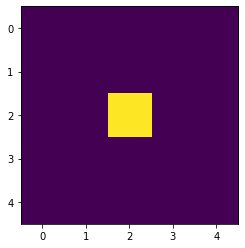

In [19]:
_k = np.ones((5,5))
_k[2,2] = 2
plt.imshow(_k)

In [20]:
from scipy.ndimage import convolve
bbb=convolve(np.clip(aaa.astype(float),0,1), _k, mode='constant', cval=0.0)

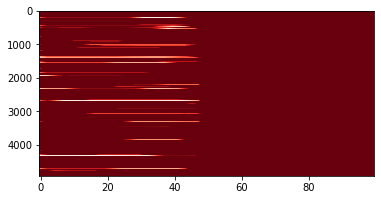

In [21]:
plt.imshow(bbb,aspect=0.01,cmap="Reds",vmin=0,vmax=1)

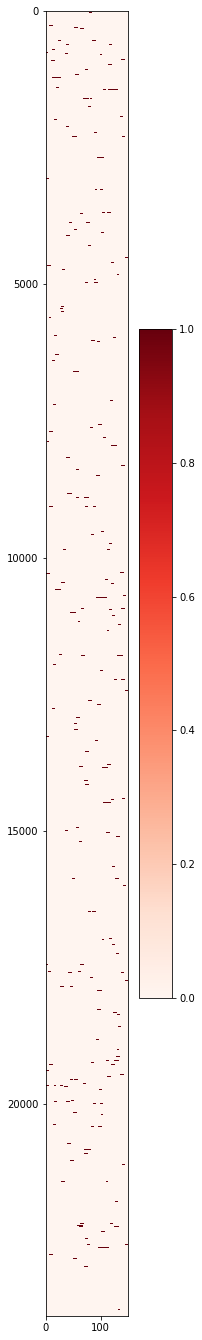

In [22]:
# SpliceDDX55aux.bb
# SpliceCTCFaux.bb
aaa = rstacks(
    "SpliceCTCFaux.bb",
    dfs["ctcf"],
    flank=15_000,
    binsize=200
)[reordered_jdxs["ctcf"]].astype(float)
bbb=convolve(np.clip(aaa.astype(float),0,1), _k, mode='constant', cval=0.0)
plt.figure(figsize=(4,24))
plt.imshow(bbb,aspect=0.1,interpolation="nearest",cmap="Reds",vmin=0,vmax=1)
plt.colorbar()

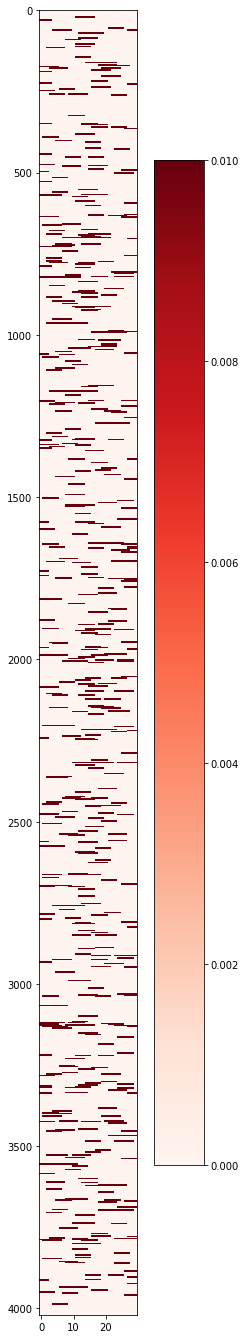

In [23]:
aaa = rstacks(
    "SpliceCTCFaux.bb",
    dfs["ctcf_g4"],
    flank=15_000,
    binsize=1_000
)[reordered_jdxs["ctcf_g4"]]
plt.figure(figsize=(6,24))
bbb=convolve(np.clip(aaa.astype(float),0,1), _k, mode='constant', cval=0.0)
plt.imshow(bbb,aspect=0.1,interpolation="none",cmap="Reds",vmin=0,vmax=.01)
plt.colorbar()

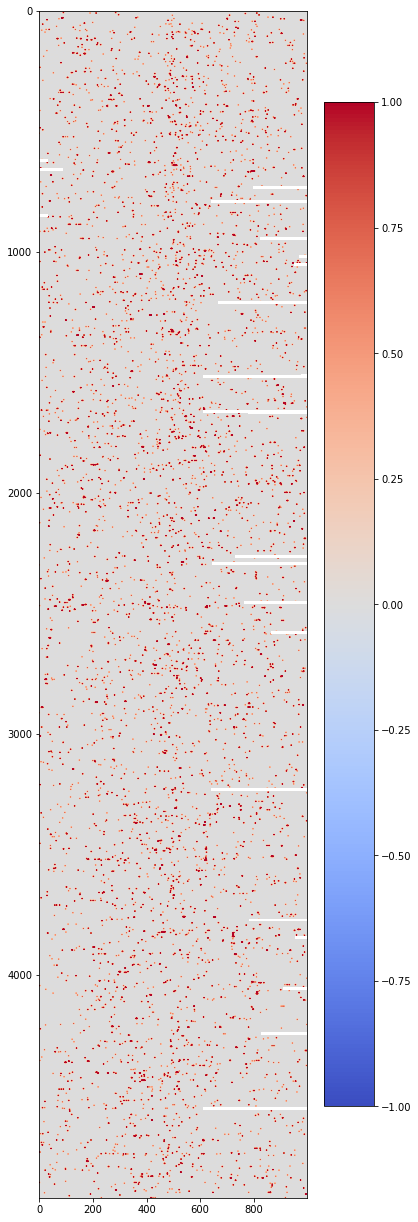

In [24]:
aaa = rstacks(
    "SpliceCTCFaux.bb",
    dfs["g4"],
    flank=250_000,
    binsize=500
)[reordered_jdxs["g4"]]
plt.figure(figsize=(6,42))
bbb=convolve(np.clip(aaa.astype(float),0,1), _k, mode='constant', cval=0.0)
plt.imshow(bbb,aspect=0.9,interpolation="bilinear",cmap="coolwarm",vmin=-1,vmax=1)
plt.colorbar()